In [1]:
import numpy as np
import pandas as pd

In [2]:
import yfinance as yf

df = yf.download('AMD', start="2015-01-01")
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,2.670000,2.670000,2.670000,2.670000,2.670000,0
2015-01-05,2.670000,2.700000,2.640000,2.660000,2.660000,8878200
2015-01-06,2.650000,2.660000,2.550000,2.630000,2.630000,13912500
2015-01-07,2.630000,2.650000,2.540000,2.580000,2.580000,12377600
2015-01-08,2.590000,2.650000,2.560000,2.610000,2.610000,11136600
...,...,...,...,...,...,...
2024-04-05,168.100006,172.690002,165.580002,170.419998,170.419998,66025200
2024-04-08,168.199997,171.660004,166.820007,169.899994,169.899994,43997500
2024-04-09,170.210007,171.600006,167.289993,170.779999,170.779999,42928000


In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_df = scaler.fit_transform(df[['Close']].values)
scaled_df

array([[-1.03336383],
       [-1.03357625],
       [-1.0342135 ],
       ...,
       [ 2.53761825],
       [ 2.46029761],
       [ 2.53167053]])

In [4]:
# Define parameters
input_length = 100  # Number of time steps to look back
output_length = 20  # Number of time steps to predict ahead
n_features = 1  # Number of input features (only 'Close' price)
n_units = 64  # Number of units in GRU layers
dropout_rate = 0.2  # Dropout rate

In [5]:
# Create time series batches
X, Y = [], []
for i in range(len(scaled_df) - input_length - output_length + 1):
    X.append(scaled_df[i:i+input_length])
    Y.append(scaled_df[i+input_length:i+input_length+output_length])

X = np.array(X)
Y = np.array(Y)

In [6]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam

# Define LSTM model
model = Sequential([
    LSTM(units=n_units, input_shape=(input_length, n_features), return_sequences=True),
    Dropout(dropout_rate),
    LSTM(units=n_units),
    Dropout(dropout_rate),
    Dense(units=output_length)
])

# Compile model
model.compile(optimizer=Adam(), loss='mse')

c:\Users\j584l\Downloads\Projects\stock-price-forecasting\env1\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [7]:
from keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(X, Y, epochs=100, validation_split=0.2, callbacks=[callback])

Epoch 1/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 0.3973 - val_loss: 0.2870
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0459 - val_loss: 0.1416
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0365 - val_loss: 0.1260
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.0350 - val_loss: 0.1408
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.0334 - val_loss: 0.1087
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0312 - val_loss: 0.1388
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.0286 - val_loss: 0.0988
Epoch 8/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.0262 - val_loss: 0.1253
Epoch 9/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0312 - val_loss: 0.1232
Epoch 10/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.0269 - val_loss: 0.1255
Epoch 11/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.0290 - val_loss: 0.0927
Epoch 12/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step

In [ ]:
# Predictions
def predict_all(model, data, input_length, output_length):
    predictions = []
    for i in range(len(data) - input_length + 1):
        input_data = data[i:i+input_length].reshape(1, input_length, n_features)
        pred = model.predict(input_data).reshape(output_length)
        predictions.append(pred)
    return np.array(predictions)

scaled_preds = predict_all(model, scaled_df, input_length, output_length)
preds = scaler.inverse_transform(scaled_preds)

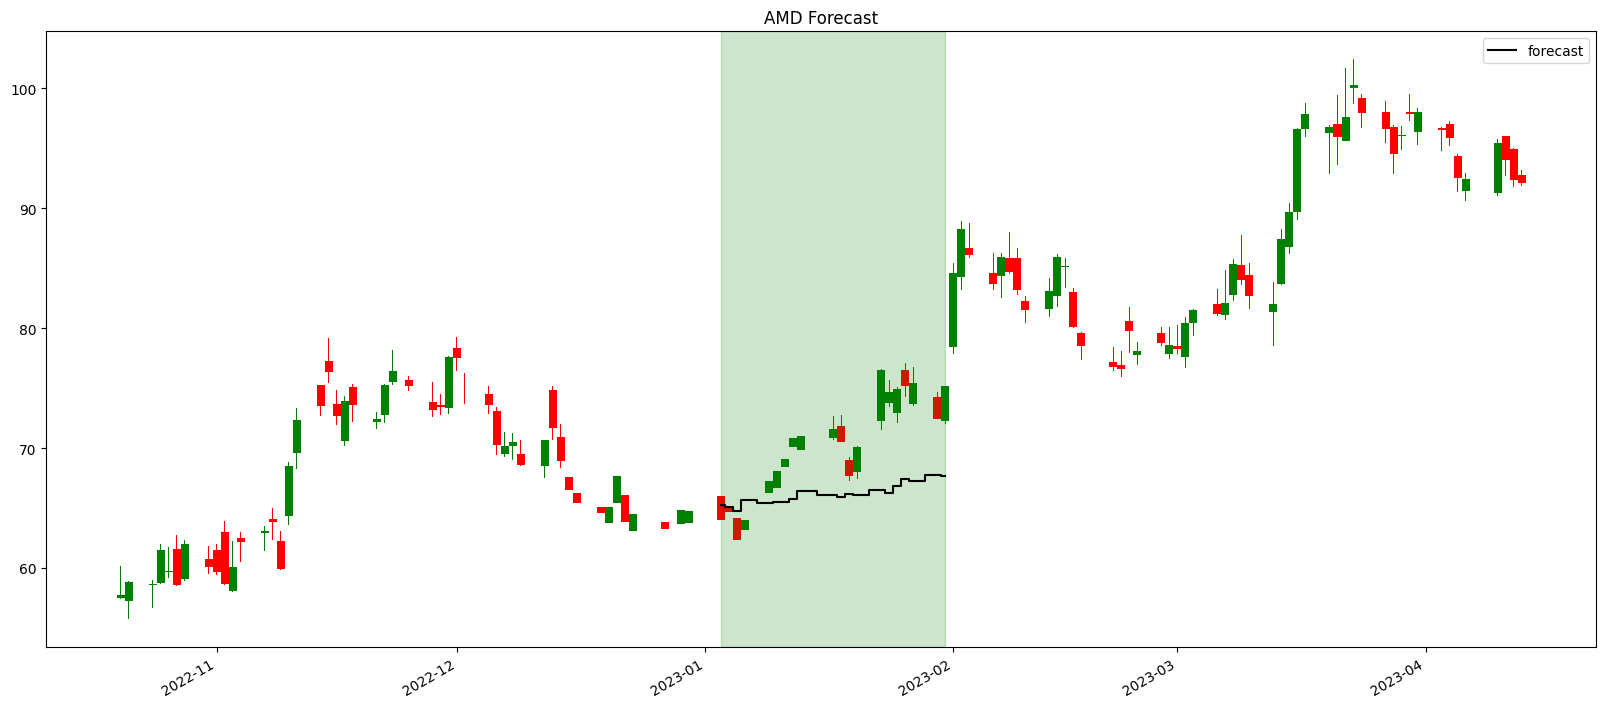

In [24]:
import matplotlib.pyplot as plt 

candles_back = 300
lpadding = 50
rpadding = 50

rlim = rpadding-candles_back if candles_back > rpadding else None

df_display = df.iloc[-lpadding-output_length-candles_back:rlim]

up = df_display[df_display['Close'] >= df_display['Open']]
down = df_display[df_display['Close'] < df_display['Open']] 
col1 = 'green'
col2 = 'red'
width = 1
width2 = .1


plt.figure(figsize=(20,8))

# Plotting up prices of the stock 
plt.bar(up.index, up['Close']-up['Open'], width, bottom=up['Open'], color=col1) 
plt.bar(up.index, up['High']-up['Close'], width2, bottom=up['Close'], color=col1) 
plt.bar(up.index, up['Low']-up['Open'], width2, bottom=up['Open'], color=col1) 
  
# Plotting down prices of the stock 
plt.bar(down.index, down['Close']-down['Open'], width, bottom=down['Open'], color=col2) 
plt.bar(down.index, down['High']-down['Open'], width2, bottom=down['Open'], color=col2) 
plt.bar(down.index, down['Low']-down['Close'], width2, bottom=down['Close'], color=col2) 
  
plt.step(df_display.index[lpadding:lpadding+output_length], preds[-output_length-candles_back-1], where='mid', label='forecast', color='black')

# rotating the x-axis tick labels at 30degree  
plt.xticks(rotation=30, ha='right') 
  
plt.legend()
plt.title('AMD Forecast')

plt.axvspan(df_display.index[lpadding], df_display.index[lpadding+output_length-1], color='green', alpha=0.2)
  
plt.show() 